# Introduction

### Import libraries

In [4]:
import pandas as pd
import numpy as np
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Load data

In [5]:
common_voices_train_df = pd.read_csv(r'E:\common_voices\uk\train.tsv', sep='\t')
common_voices_test_df = pd.read_csv(r'E:\common_voices\uk\test.tsv', sep='\t')

In [6]:
common_voices_train_df = (common_voices_train_df[['client_id', 'path', 'sentence', 'gender']]).dropna()
common_voices_test_df = (common_voices_test_df[['client_id', 'path', 'sentence', 'gender']]).dropna()

In [7]:
common_voices_train_sample = common_voices_train_df.sample(n=1000, random_state=1)
common_voices_test_sample = common_voices_test_df.sample(n=100, random_state=1)

In [8]:
def sex(x):
    if x == 'male': return 1
    else: return 0

common_voices_train_sample.gender = common_voices_train_sample.gender.apply(sex)
common_voices_test_sample.gender = common_voices_test_sample.gender.apply(sex)

In [9]:
common_voices_train_sample.head(3)

,client_id,path,sentence,gender
1537,4bd1a7966133877a9acc326f7bcbddaf4e4b95aff93847...,common_voice_uk_21567233.mp3,Ці пошуки ведуть його ледь не через усю Європу.,1
2192,3b249402c2d9aa19d2138e8c7c9e11fa0aba152692ef6a...,common_voice_uk_23776436.mp3,— Ввечері дідо казав.,0
981,9368444ba57fb6d57fa0047b2d6d0c232571af0ab73fd3...,common_voice_uk_23560794.mp3,За їхньої застрашливої підтримки провів подушн...,1


In [10]:
common_voices_test_sample.head(3)

,client_id,path,sentence,gender
759,db01e067aed936a893ab2c3ca3ffb10335653c04dddd5a...,common_voice_uk_23484773.mp3,"Не було відпочинку; ні воїни, ні Полководці не...",0
3584,5bbba5bb39b8bf16bc08915256e9bb7ba80d0e922dea7f...,common_voice_uk_21567766.mp3,"В результаті отримуємо індивідуальний виріб, н...",0
2129,b48e81e53e7457723fe10be2221a84c92082a911bb0083...,common_voice_uk_22343051.mp3,Сьогодні ми повинні зробити декілька дуже важл...,1


### Work with librosa

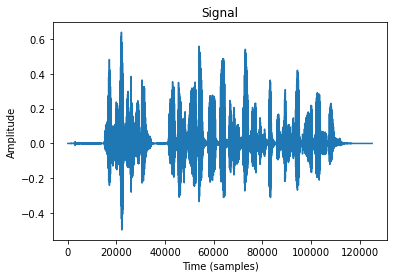

In [11]:
filename = r'E:\common_voices\uk\clips_wav_format\common_voice_uk_20894332.wav'
voice_1, sr = lr.load(filename, sr=16000)
plt.plot(voice_1);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

 Fs = 16000, x.shape = (125184,), x.dtype = float32


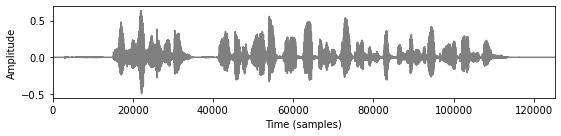

In [12]:
voice_2, sr = lr.load(r'E:\common_voices\uk\clips_wav_format\common_voice_uk_20894332.wav', sr=16000)
import IPython.display as ipd

def print_plot_play(x, Fs, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))
print_plot_play(x=voice_2, Fs=sr)

### Extract features function

In [13]:
def get_features(file_name, **boolean_kwargs): 
    """
    Chroma (chroma)
    MEL Spectrogram Frequency (mel)
    Tonnetz (tonnetz)
    Contrast (contrast)
    MFCC (mfcc)
    """
    chroma_b = boolean_kwargs.get("chroma")
    mel_b = boolean_kwargs.get("mel")
    tonnetz_b = boolean_kwargs.get("tonnetz")
    contrast_b = boolean_kwargs.get("contrast")
    mfcc_b = boolean_kwargs.get("mfcc")
    
    X, sample_rate = lr.load(file_name, sr=16000)
    
    #some transforms that are needed in Sosung tasks...
    
    #Short-time Fourier transform
    stft = np.abs(lr.stft(X))
    result = np.array([])
    
    if chroma_b:
        chroma = np.mean(lr.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel_b:
        mel = np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if tonnetz_b:
        tonnetz = np.mean(lr.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    if contrast_b:
        contrast = np.mean(lr.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if mfcc_b:
        mfccs = np.mean(lr.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    return result

# Loading voices and making dataframe

In [14]:
files = lr.util.find_files(r'E:\common_voices\uk\clips_wav_format') 
files = np.asarray(files)
len(files)

48807

In [15]:
files

array(['E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20894281.wav',
       'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20894282.wav',
       'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20894283.wav',
       ...,
       'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_27453810.wav',
       'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_27453811.wav',
       'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_27453812.wav'],
      dtype='<U65')

In [16]:
train_sample_pathes = []
for file in files:
    if (((file.split('\\')[4]).split('.'))[0] + '.mp3') in common_voices_train_sample.path.values: train_sample_pathes.append(file)

In [17]:
len(train_sample_pathes)

1000

In [18]:
test_sample_pathes = []
for file in files:
    if (((file.split('\\')[4]).split('.'))[0] + '.mp3') in common_voices_test_sample.path.values: test_sample_pathes.append(file)

In [19]:
len(test_sample_pathes)

100

In [20]:
train_sample_pathes[:3]

['E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20976995.wav',
 'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20977000.wav',
 'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20977012.wav']

In [21]:
test_sample_pathes[:3]

['E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20894285.wav',
 'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20900153.wav',
 'E:\\common_voices\\uk\\clips_wav_format\\common_voice_uk_20947498.wav']

### Extract features using our function

In [22]:
array = []
for k in range(len(train_sample_pathes)):
    features = get_features(train_sample_pathes[k], chroma=True, mel=True)
    array.append(features)

In [23]:
test_array = []
for k in range(len(test_sample_pathes)):
    features = get_features(test_sample_pathes[k], chroma=True, mel=True)
    test_array.append(features)

count of different chroma: 12, mel: 128, tonnetz: ?, contrast: 7, mfcc: 40

So, let's work with mel and chroma now

In [24]:
L = []
for j in range(140):
    if j < 12: L.append(['chroma_' + str(j)])
    else: L.append(['mel_' + str(j-12)])

In [25]:
dataframe_train = pd.DataFrame(array, columns=np.array(L))
dataframe_train['path'] = train_sample_pathes
dataframe_train.path = dataframe_train.path.str.slice(start=37, stop=61)
dataframe_train.head()

,"(chroma_0,)","(chroma_1,)","(chroma_2,)","(chroma_3,)","(chroma_4,)","(chroma_5,)","(chroma_6,)","(chroma_7,)","(chroma_8,)","(chroma_9,)",...,"(mel_119,)","(mel_120,)","(mel_121,)","(mel_122,)","(mel_123,)","(mel_124,)","(mel_125,)","(mel_126,)","(mel_127,)",path
0,0.604424,0.671372,0.655869,0.586759,0.586307,0.568976,0.521526,0.517717,0.582135,0.588473,...,0.004734,0.007616,0.009703,0.009490,0.008738,0.010453,0.005716,0.001605,0.000182,common_voice_uk_20976995
1,0.670749,0.681152,0.591979,0.544315,0.545421,0.514061,0.486521,0.496444,0.527814,0.550978,...,0.007625,0.008075,0.014375,0.028553,0.027761,0.019436,0.011688,0.001286,0.000034,common_voice_uk_20977000
2,0.683730,0.707482,0.657285,0.614849,0.597914,0.495775,0.472155,0.537346,0.599073,0.565924,...,0.000926,0.002525,0.002910,0.002323,0.001075,0.000835,0.000458,0.000115,0.000009,common_voice_uk_20977012
3,0.606890,0.561492,0.484264,0.467166,0.455695,0.513558,0.597687,0.722876,0.827175,0.753132,...,0.095345,0.100990,0.052418,0.042419,0.034713,0.022615,0.011858,0.002370,0.000054,common_voice_uk_21022364
4,0.651191,0.623914,0.531385,0.458568,0.447586,0.535494,0.689135,0.763579,0.758200,0.695796,...,0.029203,0.031108,0.025105,0.029689,0.029171,0.027081,0.021992,0.004849,0.000361,common_voice_uk_21022974


In [26]:
dataframe_test = pd.DataFrame(test_array, columns=np.array(L))
dataframe_test['path'] = test_sample_pathes
dataframe_test.path = dataframe_test.path.str.slice(start=37, stop=61)
dataframe_test.head()

,"(chroma_0,)","(chroma_1,)","(chroma_2,)","(chroma_3,)","(chroma_4,)","(chroma_5,)","(chroma_6,)","(chroma_7,)","(chroma_8,)","(chroma_9,)",...,"(mel_119,)","(mel_120,)","(mel_121,)","(mel_122,)","(mel_123,)","(mel_124,)","(mel_125,)","(mel_126,)","(mel_127,)",path
0,0.544923,0.613200,0.616107,0.712091,0.706456,0.676013,0.746869,0.692190,0.684600,0.718065,...,0.000524,0.000652,0.000661,0.000525,0.000340,0.000260,0.000085,9.633357e-06,1.520030e-07,common_voice_uk_20894285
1,0.564727,0.622960,0.595116,0.564571,0.641902,0.709211,0.725173,0.724130,0.722265,0.752774,...,0.006148,0.001422,0.000224,0.000264,0.000200,0.000065,0.000008,6.852134e-07,2.456295e-08,common_voice_uk_20900153
2,0.537237,0.476176,0.474434,0.445946,0.411323,0.422319,0.441292,0.482165,0.519177,0.578512,...,0.000263,0.000366,0.000269,0.000243,0.000092,0.000047,0.000010,6.074420e-07,1.556034e-08,common_voice_uk_20947498
3,0.610135,0.592873,0.600644,0.616123,0.651717,0.707285,0.723993,0.725491,0.774251,0.833817,...,0.003269,0.002430,0.002126,0.002238,0.001151,0.000615,0.000189,4.432181e-05,9.191899e-07,common_voice_uk_20948506
4,0.630542,0.525713,0.529110,0.551996,0.500083,0.496456,0.536310,0.626285,0.689926,0.709380,...,0.002454,0.001507,0.002240,0.000843,0.000439,0.000990,0.000668,3.871995e-05,2.996177e-06,common_voice_uk_20987014


In [27]:
common_voices_train_sample.path = common_voices_train_sample.path.str.slice(start=0, stop=24)

In [28]:
common_voices_test_sample.path = common_voices_test_sample.path.str.slice(start=0, stop=24)

### Merge datasets

In [29]:
merged_train_dataframe = pd.merge(dataframe_train, common_voices_train_sample, on='path')
merged_test_dataframe = pd.merge(dataframe_test, common_voices_test_sample, on='path')

In [30]:
merged_train_dataframe.shape, merged_test_dataframe.shape

((1000, 144), (100, 144))

In [31]:
merged_train_dataframe.head(3)

,"(chroma_0,)","(chroma_1,)","(chroma_2,)","(chroma_3,)","(chroma_4,)","(chroma_5,)","(chroma_6,)","(chroma_7,)","(chroma_8,)","(chroma_9,)",...,"(mel_122,)","(mel_123,)","(mel_124,)","(mel_125,)","(mel_126,)","(mel_127,)",path,client_id,sentence,gender
0,0.604424,0.671372,0.655869,0.586759,0.586307,0.568976,0.521526,0.517717,0.582135,0.588473,...,0.009490,0.008738,0.010453,0.005716,0.001605,0.000182,common_voice_uk_20976995,956118f093187a03e2e3c311e5eb9886344f1488f7c323...,Потий сонце зійде — роса очи виїсть.,1
1,0.670749,0.681152,0.591979,0.544315,0.545421,0.514061,0.486521,0.496444,0.527814,0.550978,...,0.028553,0.027761,0.019436,0.011688,0.001286,0.000034,common_voice_uk_20977000,956118f093187a03e2e3c311e5eb9886344f1488f7c323...,"Будучи одиницею членування тексту, абзац посід...",1
2,0.683730,0.707482,0.657285,0.614849,0.597914,0.495775,0.472155,0.537346,0.599073,0.565924,...,0.002323,0.001075,0.000835,0.000458,0.000115,0.000009,common_voice_uk_20977012,956118f093187a03e2e3c311e5eb9886344f1488f7c323...,Тому воно також буде враховано.,1


# Modeling

In [32]:
X_train = merged_train_dataframe.drop(columns = ['path', 'client_id', 'sentence', 'gender'], axis=1)
y_train = merged_train_dataframe.gender

In [33]:
X_test = merged_test_dataframe.drop(columns = ['path', 'client_id', 'sentence', 'gender'], axis=1)
y_test = merged_test_dataframe.gender
y_test_array = y_test.to_numpy()

In [34]:
parametrs = {'n_estimators':range(5,41,5),
    'max_depth':range(1,9,2),
    'min_samples_leaf':range(1,8),
    'min_samples_split':range(2,4)}
voice_rf = RandomForestClassifier(random_state=0)
search = GridSearchCV(voice_rf, parametrs, n_jobs=-1, cv=3)
search.fit(X_train,y_train)
best_voice_forest = search.best_estimator_ 

In [35]:
predictions = best_voice_forest.predict(X_test)

In [36]:
(predictions == y_test_array).sum()

85

In [41]:
len(y_test_array)

100

Accuracy is 85/100, 85%

# Check results

In [38]:
predictions

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], dtype=int64)

In [39]:
y_test_array

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], dtype=int64)

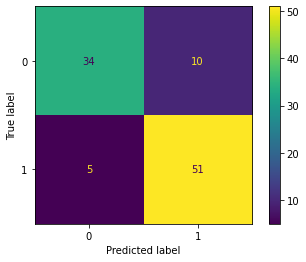

In [40]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_voice_forest, X_test, y_test)  
plt.show()

Our model erroneously identified female voices as male in most cases, so we must take this into account